# Offset center-of-mass computations

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
from tqdm import tqdm

%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
rc('text', usetex=True)

cases = ["CB{:1d}".format(i) for i in range(1, 5)]
print("Case names : ", cases)

data_path = "../data/32_cells/"
output_path = "../output/"

output_cases = [output_path + case for case in cases]
for path in output_cases:
    !mkdir -p $path

Case names :  ['CB1', 'CB2', 'CB3', 'CB4']


In [2]:
def read_fortran_formatting(path, first_row):
    with open(path, "r") as file:
        all_rows = file.readlines()
        all_rows_clean = []
        for row in all_rows[first_row:]:
            tokens = row.split(" ")
            all_rows_clean.append([float(x) for x in tokens if x not in ["", "\n"]])
        return all_rows_clean

In [4]:
columns = [
    "t",
    "ub_x", "ub_y", "ub_z",
    "vb",
    "cb_x", "cb_y", "cb_z",
    "db_x", "db_y", "db_z",
    "rm_add", "rm_rem", "rm_pyr",
    "p_jump",
    "ul_x", "ul_y", "ul_z"
]

log_files = {}
for case in cases:
    log_path = data_path + case + "/bub0000.log"
    print("Processing file {:s}".format(log_path))
    raw_data = read_fortran_formatting(log_path, first_row=5)
    log_files[case] = pd.DataFrame(np.asarray(raw_data), columns=columns)
    log_files[case].to_pickle(output_path + case + "/log_file.pkl")
    print("-"*100)

Processing file ../data/32_cells/CB1/bub0000.log
----------------------------------------------------------------------------------------------------
Processing file ../data/32_cells/CB2/bub0000.log
----------------------------------------------------------------------------------------------------
Processing file ../data/32_cells/CB3/bub0000.log
----------------------------------------------------------------------------------------------------
Processing file ../data/32_cells/CB4/bub0000.log
----------------------------------------------------------------------------------------------------


In [7]:
def load_snapshot(path):
    """Load snapshot from disk and convert to DataFrame."""
    columns = ["x", "y", "z", "v_x", "v_y", "v_z", "n_x", "n_y", "n_z"]
    raw_data = read_fortran_formatting(path, first_row=1)
    return pd.DataFrame(np.asarray(raw_data), columns=columns)

In [26]:
center_cloud = dict()
time_cloud = dict()

for case in cases:
    data_files = glob(data_path + case + "/PointData*")
    iterations = sorted([int(file_name[-10:-4]) for file_name in data_files])
    center = np.zeros((len(iterations), 3))
    time = np.zeros(len(iterations))
    for i, iteration in enumerate(tqdm(iterations)):
        file_path = data_path + case + "/PointData{:06d}.dat".format(iteration)
        data = load_snapshot(file_path)
        center[i] = np.mean(data[["x", "y", "z"]].values, axis=0)
        log_row = log_files[case].iloc[iteration]
        time[i] = log_row.t
    center_cloud[case] = np.copy(center)
    time_cloud[case] = np.copy(time)

100%|██████████| 1003/1003 [02:30<00:00,  6.40it/s]


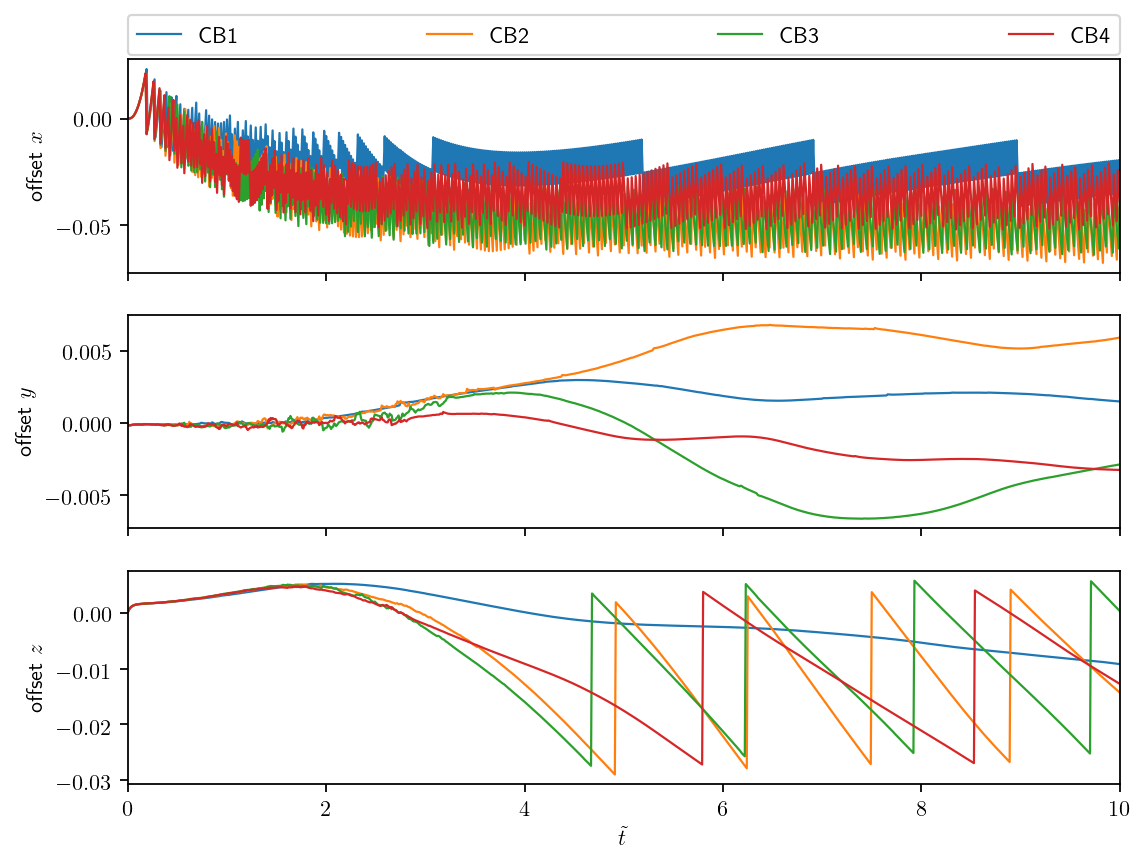

In [28]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for case in cases:
    data = log_files[case]
    cloud_center = center_cloud[case]
    cloud_time = time_cloud[case]
    axarr[0].plot(cloud_time, cloud_center[:, 0]-data.cb_x[0], ls="-", lw=1, label=case)
    axarr[0].set_ylabel(r"offset $x$")
    axarr[1].plot(cloud_time, cloud_center[:, 1]-data.cb_y[0], ls="-", lw=1, label=case)
    axarr[1].set_ylabel(r"offset $y$")
    axarr[2].plot(cloud_time, cloud_center[:, 2]-data.cb_z[0], ls="-", lw=1, label=case)
    axarr[2].set_ylabel(r"offset $z$")

axarr[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.,)
axarr[-1].set_xlabel(r"$\tilde{t}$")
axarr[-1].set_xlim(0.0, 10)

plt.show()

In [41]:
times = np.linspace(1.0, 10.0, 10)
all_offsets = dict()

for case in cases:
    offsets = np.zeros((10, 3))
    for i, time in enumerate(times):
        for j, t in enumerate(time_cloud[case]):
            if t > time:
                #print(time_cloud[case][j-1])
                offsets[i] =  center_cloud[case][j-1] - center_cloud[case][0]
                break
    all_offsets[case] = np.copy(offsets)

In [44]:
for case in cases:
    print("Offsets for case {:s}".format(case))
    print("-"*20)
    for i, time in enumerate(times):
        print("t={:2.1f}, offset x/y/z".format(time))
        print(all_offsets[case][i])
    print("-"*20)
        

Offsets for case CB1
--------------------
t=1.0, offset x/y/z
[-5.17897073e-04 -1.80994606e-05  2.82790938e-03]
t=2.0, offset x/y/z
[-0.00829054  0.00033655  0.00483739]
t=3.0, offset x/y/z
[-0.03835222  0.00160669  0.00310824]
t=4.0, offset x/y/z
[-0.01596632  0.00264044 -0.00027637]
t=5.0, offset x/y/z
[-0.01132293  0.0027993  -0.00235295]
t=6.0, offset x/y/z
[-0.03408082  0.00185514 -0.00292829]
t=7.0, offset x/y/z
[-0.02493558  0.00166823 -0.0039486 ]
t=8.0, offset x/y/z
[-0.01699024  0.00201371 -0.00576852]
t=9.0, offset x/y/z
[-0.04125888  0.00201174 -0.00777225]
t=10.0, offset x/y/z
[0. 0. 0.]
--------------------
Offsets for case CB2
--------------------
t=1.0, offset x/y/z
[-0.02491817 -0.00018771  0.00303234]
t=2.0, offset x/y/z
[-0.04009307  0.0005036   0.00418978]
t=3.0, offset x/y/z
[-0.03326129  0.00156371 -0.00079944]
t=4.0, offset x/y/z
[-0.05739802  0.0027451  -0.01322269]
t=5.0, offset x/y/z
[-5.97419985e-02  4.34870080e-03 -5.29693302e-05]
t=6.0, offset x/y/z
[-0.057